# **Implementation of GANs in Fashion Mnist Data**

In [ ]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [ ]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28, 1)


In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [ ]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [ ]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [ ]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [ ]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
discriminator = define_discriminator()

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model
generator = define_generator(100)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
gan_model = define_gan(generator, discriminator)

In [ ]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

2/2 [==============================] - 0s 11ms/step
>1, dr[0.874,0.328], df[0.698,0.125], g[0.689,0.922]
2/2 [==============================] - 0s 7ms/step
>2, dr[0.128,0.984], df[0.709,0.000], g[0.680,1.000]
2/2 [==============================] - 0s 8ms/step
>3, dr[0.070,1.000], df[0.720,0.000], g[0.669,1.000]
2/2 [==============================] - 0s 8ms/step
>4, dr[0.021,1.000], df[0.736,0.000], g[0.656,1.000]
2/2 [==============================] - 0s 7ms/step
>5, dr[0.017,1.000], df[0.754,0.000], g[0.641,1.000]
2/2 [==============================] - 0s 7ms/step
>6, dr[0.019,1.000], df[0.780,0.000], g[0.624,1.000]
2/2 [==============================] - 0s 8ms/step
>7, dr[0.011,1.000], df[0.809,0.000], g[0.604,1.000]
2/2 [==============================] - 0s 8ms/step
>8, dr[0.014,1.000], df[0.842,0.000], g[0.595,1.000]
2/2 [==============================] - 0s 7ms/step
>9, dr[0.011,1.000], df[0.855,0.000], g[0.593,1.000]
2/2 [==============================] - 0s 7ms/step
>10, dr[0.01

>Saved: model_0937.h5
2/2 [==============================] - 0s 8ms/step
>938, dr[0.335,0.828], df[0.358,0.859], g[2.802,0.031]
2/2 [==============================] - 0s 7ms/step
>939, dr[0.330,0.844], df[0.186,0.984], g[2.490,0.016]
2/2 [==============================] - 0s 7ms/step
>940, dr[0.367,0.828], df[0.560,0.781], g[3.290,0.000]
2/2 [==============================] - 0s 7ms/step
>941, dr[0.526,0.750], df[0.264,0.938], g[2.493,0.000]
2/2 [==============================] - 0s 8ms/step
>942, dr[0.217,0.906], df[0.396,0.828], g[3.207,0.031]
2/2 [==============================] - 0s 8ms/step
>943, dr[0.518,0.734], df[0.308,0.859], g[2.544,0.016]
2/2 [==============================] - 0s 10ms/step
>944, dr[0.216,0.922], df[0.424,0.844], g[2.716,0.000]
2/2 [==============================] - 0s 13ms/step
>945, dr[0.413,0.781], df[0.267,0.922], g[2.821,0.000]
2/2 [==============================] - 0s 8ms/step
>946, dr[0.474,0.766], df[0.598,0.766], g[3.033,0.016]
2/2 [=================

>Saved: model_1874.h5
2/2 [==============================] - 0s 8ms/step
>1875, dr[0.500,0.750], df[0.408,0.891], g[1.967,0.062]
2/2 [==============================] - 0s 8ms/step
>1876, dr[0.374,0.766], df[0.424,0.891], g[2.048,0.016]
2/2 [==============================] - 0s 9ms/step
>1877, dr[0.381,0.766], df[0.403,0.859], g[2.171,0.031]
2/2 [==============================] - 0s 9ms/step
>1878, dr[0.524,0.641], df[0.406,0.891], g[2.242,0.016]
2/2 [==============================] - 0s 9ms/step
>1879, dr[0.554,0.641], df[0.468,0.859], g[2.088,0.000]
2/2 [==============================] - 0s 9ms/step
>1880, dr[0.481,0.656], df[0.403,0.891], g[1.907,0.047]
2/2 [==============================] - 0s 8ms/step
>1881, dr[0.421,0.781], df[0.400,0.891], g[1.910,0.016]
2/2 [==============================] - 0s 9ms/step
>1882, dr[0.400,0.750], df[0.429,0.875], g[1.859,0.062]
2/2 [==============================] - 0s 11ms/step
>1883, dr[0.430,0.734], df[0.464,0.906], g[2.069,0.016]
2/2 [=========

>Saved: model_2811.h5
2/2 [==============================] - 0s 14ms/step
>2812, dr[0.359,0.734], df[0.492,0.781], g[2.232,0.000]
2/2 [==============================] - 0s 9ms/step
>2813, dr[0.394,0.781], df[0.207,1.000], g[2.066,0.016]
2/2 [==============================] - 0s 8ms/step
>2814, dr[0.491,0.750], df[0.398,0.891], g[1.992,0.062]
2/2 [==============================] - 0s 13ms/step
>2815, dr[0.456,0.750], df[0.438,0.875], g[1.912,0.000]
2/2 [==============================] - 0s 13ms/step
>2816, dr[0.394,0.781], df[0.560,0.766], g[2.035,0.031]
2/2 [==============================] - 0s 10ms/step
>2817, dr[0.492,0.719], df[0.401,0.891], g[2.049,0.031]
2/2 [==============================] - 0s 8ms/step
>2818, dr[0.515,0.656], df[0.332,0.953], g[1.706,0.031]
2/2 [==============================] - 0s 13ms/step
>2819, dr[0.268,0.875], df[0.379,0.906], g[1.689,0.203]
2/2 [==============================] - 0s 11ms/step
>2820, dr[0.454,0.703], df[0.474,0.828], g[1.653,0.078]
2/2 [====

>Saved: model_3748.h5
2/2 [==============================] - 0s 19ms/step
>3749, dr[0.481,0.688], df[0.535,0.844], g[1.616,0.047]
2/2 [==============================] - 0s 11ms/step
>3750, dr[0.688,0.547], df[0.485,0.844], g[1.436,0.078]
2/2 [==============================] - 0s 9ms/step
>3751, dr[0.635,0.578], df[0.459,0.891], g[1.364,0.062]
2/2 [==============================] - 0s 10ms/step
>3752, dr[0.551,0.656], df[0.503,0.766], g[1.397,0.078]
2/2 [==============================] - 0s 8ms/step
>3753, dr[0.609,0.578], df[0.424,0.875], g[1.545,0.062]
2/2 [==============================] - 0s 10ms/step
>3754, dr[0.683,0.547], df[0.554,0.781], g[1.362,0.016]
2/2 [==============================] - 0s 17ms/step
>3755, dr[0.624,0.562], df[0.446,0.875], g[1.362,0.125]
2/2 [==============================] - 0s 10ms/step
>3756, dr[0.466,0.750], df[0.518,0.812], g[1.326,0.156]
2/2 [==============================] - 0s 10ms/step
>3757, dr[0.538,0.578], df[0.477,0.844], g[1.336,0.094]
2/2 [===

>Saved: model_4685.h5
2/2 [==============================] - 0s 13ms/step
>4686, dr[0.561,0.672], df[0.528,0.828], g[1.250,0.125]
2/2 [==============================] - 0s 12ms/step
>4687, dr[0.626,0.609], df[0.493,0.859], g[1.216,0.125]
2/2 [==============================] - 0s 8ms/step
>4688, dr[0.471,0.672], df[0.561,0.781], g[1.324,0.078]
2/2 [==============================] - 0s 11ms/step
>4689, dr[0.395,0.734], df[0.430,0.859], g[1.370,0.094]
2/2 [==============================] - 0s 7ms/step
>4690, dr[0.689,0.531], df[0.607,0.797], g[1.284,0.078]
2/2 [==============================] - 0s 8ms/step
>4691, dr[0.603,0.641], df[0.635,0.750], g[1.470,0.047]
2/2 [==============================] - 0s 9ms/step
>4692, dr[0.530,0.641], df[0.533,0.766], g[1.423,0.078]
2/2 [==============================] - 0s 11ms/step
>4693, dr[0.528,0.656], df[0.445,0.891], g[1.492,0.094]
2/2 [==============================] - 0s 9ms/step
>4694, dr[0.678,0.641], df[0.481,0.875], g[1.482,0.094]
2/2 [======

>Saved: model_5622.h5
2/2 [==============================] - 0s 10ms/step
>5623, dr[0.633,0.594], df[0.544,0.750], g[1.456,0.078]
2/2 [==============================] - 0s 9ms/step
>5624, dr[0.574,0.656], df[0.514,0.828], g[1.361,0.094]
2/2 [==============================] - 0s 7ms/step
>5625, dr[0.723,0.453], df[0.428,0.828], g[1.335,0.078]
2/2 [==============================] - 0s 12ms/step
>5626, dr[0.532,0.656], df[0.625,0.672], g[1.276,0.109]
2/2 [==============================] - 0s 10ms/step
>5627, dr[0.648,0.531], df[0.465,0.875], g[1.149,0.141]
2/2 [==============================] - 0s 9ms/step
>5628, dr[0.550,0.625], df[0.482,0.844], g[1.178,0.250]
2/2 [==============================] - 0s 9ms/step
>5629, dr[0.634,0.578], df[0.560,0.812], g[1.125,0.156]
2/2 [==============================] - 0s 9ms/step
>5630, dr[0.715,0.516], df[0.520,0.844], g[1.114,0.156]
2/2 [==============================] - 0s 10ms/step
>5631, dr[0.628,0.531], df[0.518,0.812], g[0.984,0.266]
2/2 [======

>Saved: model_6559.h5
2/2 [==============================] - 0s 13ms/step
>6560, dr[0.586,0.578], df[0.505,0.844], g[1.140,0.125]
2/2 [==============================] - 0s 8ms/step
>6561, dr[0.624,0.562], df[0.538,0.828], g[1.323,0.094]
2/2 [==============================] - 0s 14ms/step
>6562, dr[0.604,0.656], df[0.515,0.812], g[1.111,0.203]
2/2 [==============================] - 0s 8ms/step
>6563, dr[0.601,0.625], df[0.559,0.750], g[1.082,0.172]
2/2 [==============================] - 0s 8ms/step
>6564, dr[0.506,0.703], df[0.615,0.703], g[0.964,0.219]
2/2 [==============================] - 0s 17ms/step
>6565, dr[0.498,0.688], df[0.577,0.781], g[1.022,0.188]
2/2 [==============================] - 0s 11ms/step
>6566, dr[0.573,0.594], df[0.583,0.844], g[1.235,0.109]
2/2 [==============================] - 0s 9ms/step
>6567, dr[0.679,0.562], df[0.572,0.750], g[1.246,0.094]
2/2 [==============================] - 0s 9ms/step
>6568, dr[0.561,0.625], df[0.637,0.750], g[1.172,0.078]
2/2 [======

>Saved: model_7496.h5
2/2 [==============================] - 0s 9ms/step
>7497, dr[0.531,0.641], df[0.610,0.828], g[1.157,0.141]
2/2 [==============================] - 0s 12ms/step
>7498, dr[0.656,0.531], df[0.478,0.812], g[1.134,0.125]
2/2 [==============================] - 0s 11ms/step
>7499, dr[0.602,0.625], df[0.678,0.641], g[1.114,0.188]
2/2 [==============================] - 0s 10ms/step
>7500, dr[0.663,0.516], df[0.673,0.672], g[1.251,0.078]
2/2 [==============================] - 0s 8ms/step
>7501, dr[0.567,0.672], df[0.514,0.812], g[1.242,0.062]
2/2 [==============================] - 0s 10ms/step
>7502, dr[0.618,0.609], df[0.639,0.719], g[1.214,0.141]
2/2 [==============================] - 0s 11ms/step
>7503, dr[0.639,0.578], df[0.560,0.750], g[1.161,0.141]
2/2 [==============================] - 0s 16ms/step
>7504, dr[0.638,0.578], df[0.651,0.781], g[1.210,0.125]
2/2 [==============================] - 0s 10ms/step
>7505, dr[0.581,0.656], df[0.640,0.781], g[1.103,0.141]
2/2 [===

>Saved: model_8433.h5
2/2 [==============================] - 0s 13ms/step
>8434, dr[0.566,0.656], df[0.591,0.672], g[1.138,0.172]
2/2 [==============================] - 0s 13ms/step
>8435, dr[0.673,0.531], df[0.659,0.703], g[1.110,0.125]
2/2 [==============================] - 0s 7ms/step
>8436, dr[0.672,0.531], df[0.628,0.766], g[1.136,0.141]
2/2 [==============================] - 0s 9ms/step
>8437, dr[0.731,0.438], df[0.560,0.812], g[1.084,0.062]
2/2 [==============================] - 0s 13ms/step
>8438, dr[0.652,0.594], df[0.591,0.734], g[1.061,0.109]
2/2 [==============================] - 0s 8ms/step
>8439, dr[0.620,0.609], df[0.536,0.766], g[1.126,0.141]
2/2 [==============================] - 0s 7ms/step
>8440, dr[0.588,0.594], df[0.628,0.781], g[1.177,0.109]
2/2 [==============================] - 0s 10ms/step
>8441, dr[0.633,0.547], df[0.557,0.812], g[1.058,0.094]
2/2 [==============================] - 0s 9ms/step
>8442, dr[0.712,0.484], df[0.494,0.844], g[1.057,0.156]
2/2 [======

>Saved: model_9370.h5
2/2 [==============================] - 0s 14ms/step
>9371, dr[0.663,0.516], df[0.675,0.734], g[1.094,0.125]
2/2 [==============================] - 0s 9ms/step
>9372, dr[0.672,0.484], df[0.519,0.812], g[1.032,0.172]
2/2 [==============================] - 0s 11ms/step
>9373, dr[0.563,0.625], df[0.570,0.781], g[1.055,0.188]
2/2 [==============================] - 0s 12ms/step
>9374, dr[0.579,0.562], df[0.549,0.797], g[1.061,0.141]
2/2 [==============================] - 0s 9ms/step
>9375, dr[0.574,0.688], df[0.682,0.672], g[0.943,0.250]
2/2 [==============================] - 0s 14ms/step
>9376, dr[0.625,0.562], df[0.601,0.766], g[1.047,0.125]
2/2 [==============================] - 0s 8ms/step
>9377, dr[0.480,0.734], df[0.630,0.656], g[1.108,0.141]
2/2 [==============================] - 0s 13ms/step
>9378, dr[0.647,0.516], df[0.542,0.812], g[1.127,0.062]
2/2 [==============================] - 0s 11ms/step
>9379, dr[0.675,0.500], df[0.633,0.734], g[1.122,0.125]
2/2 [====

>Saved: model_10307.h5
2/2 [==============================] - 0s 9ms/step
>10308, dr[0.587,0.625], df[0.628,0.797], g[1.041,0.203]
2/2 [==============================] - 0s 11ms/step
>10309, dr[0.644,0.516], df[0.651,0.734], g[1.090,0.156]
2/2 [==============================] - 0s 7ms/step
>10310, dr[0.710,0.406], df[0.557,0.828], g[1.074,0.141]
2/2 [==============================] - 0s 6ms/step
>10311, dr[0.712,0.516], df[0.616,0.688], g[0.970,0.172]
2/2 [==============================] - 0s 10ms/step
>10312, dr[0.601,0.562], df[0.607,0.766], g[1.058,0.156]
2/2 [==============================] - 0s 15ms/step
>10313, dr[0.702,0.484], df[0.623,0.703], g[1.024,0.141]
2/2 [==============================] - 0s 10ms/step
>10314, dr[0.524,0.672], df[0.649,0.656], g[1.015,0.172]
2/2 [==============================] - 0s 9ms/step
>10315, dr[0.601,0.578], df[0.642,0.750], g[1.081,0.188]
2/2 [==============================] - 0s 8ms/step
>10316, dr[0.602,0.625], df[0.594,0.750], g[1.049,0.156]
2

>Saved: model_11244.h5
2/2 [==============================] - 0s 13ms/step
>11245, dr[0.575,0.625], df[0.647,0.781], g[1.037,0.188]
2/2 [==============================] - 0s 11ms/step
>11246, dr[0.679,0.500], df[0.594,0.766], g[1.005,0.156]
2/2 [==============================] - 0s 14ms/step
>11247, dr[0.568,0.625], df[0.610,0.781], g[1.084,0.156]
2/2 [==============================] - 0s 12ms/step
>11248, dr[0.704,0.469], df[0.565,0.750], g[1.056,0.094]
2/2 [==============================] - 0s 8ms/step
>11249, dr[0.597,0.609], df[0.616,0.672], g[1.043,0.125]
2/2 [==============================] - 0s 8ms/step
>11250, dr[0.565,0.641], df[0.670,0.703], g[1.067,0.203]
2/2 [==============================] - 0s 11ms/step
>11251, dr[0.594,0.672], df[0.516,0.797], g[1.062,0.172]
2/2 [==============================] - 0s 8ms/step
>11252, dr[0.642,0.609], df[0.665,0.656], g[1.010,0.172]
2/2 [==============================] - 0s 9ms/step
>11253, dr[0.599,0.578], df[0.554,0.828], g[1.010,0.156]


>Saved: model_12181.h5
2/2 [==============================] - 0s 7ms/step
>12182, dr[0.518,0.719], df[0.654,0.750], g[0.945,0.156]
2/2 [==============================] - 0s 7ms/step
>12183, dr[0.590,0.625], df[0.624,0.734], g[1.033,0.125]
2/2 [==============================] - 0s 9ms/step
>12184, dr[0.581,0.578], df[0.555,0.750], g[1.049,0.125]
2/2 [==============================] - 0s 8ms/step
>12185, dr[0.625,0.578], df[0.558,0.750], g[1.028,0.172]
2/2 [==============================] - 0s 11ms/step
>12186, dr[0.551,0.641], df[0.600,0.703], g[1.005,0.078]
2/2 [==============================] - 0s 9ms/step
>12187, dr[0.548,0.656], df[0.518,0.844], g[1.016,0.078]
2/2 [==============================] - 0s 8ms/step
>12188, dr[0.612,0.578], df[0.503,0.875], g[1.037,0.156]
2/2 [==============================] - 0s 14ms/step
>12189, dr[0.565,0.625], df[0.570,0.719], g[1.049,0.219]
2/2 [==============================] - 0s 12ms/step
>12190, dr[0.611,0.578], df[0.657,0.672], g[1.106,0.062]
2/

>Saved: model_13118.h5
2/2 [==============================] - 0s 8ms/step
>13119, dr[0.673,0.562], df[0.614,0.703], g[1.023,0.156]
2/2 [==============================] - 0s 7ms/step
>13120, dr[0.607,0.594], df[0.557,0.812], g[0.924,0.281]
2/2 [==============================] - 0s 15ms/step
>13121, dr[0.605,0.594], df[0.618,0.703], g[1.015,0.203]
2/2 [==============================] - 0s 14ms/step
>13122, dr[0.555,0.609], df[0.713,0.547], g[0.961,0.250]
2/2 [==============================] - 0s 12ms/step
>13123, dr[0.643,0.516], df[0.624,0.672], g[1.053,0.234]
2/2 [==============================] - 0s 14ms/step
>13124, dr[0.682,0.516], df[0.716,0.641], g[1.013,0.172]
2/2 [==============================] - 0s 11ms/step
>13125, dr[0.698,0.484], df[0.564,0.766], g[1.006,0.203]
2/2 [==============================] - 0s 13ms/step
>13126, dr[0.569,0.609], df[0.621,0.781], g[1.048,0.156]
2/2 [==============================] - 0s 13ms/step
>13127, dr[0.629,0.516], df[0.621,0.719], g[1.112,0.078

>Saved: model_14055.h5
2/2 [==============================] - 0s 16ms/step
>14056, dr[0.634,0.609], df[0.624,0.703], g[1.008,0.125]
2/2 [==============================] - 0s 19ms/step
>14057, dr[0.676,0.547], df[0.618,0.719], g[0.990,0.188]
2/2 [==============================] - 0s 10ms/step
>14058, dr[0.546,0.688], df[0.601,0.688], g[0.978,0.203]
2/2 [==============================] - 0s 14ms/step
>14059, dr[0.602,0.594], df[0.532,0.859], g[1.010,0.141]
2/2 [==============================] - 0s 11ms/step
>14060, dr[0.542,0.672], df[0.732,0.672], g[0.980,0.219]
2/2 [==============================] - 0s 7ms/step
>14061, dr[0.628,0.562], df[0.590,0.719], g[1.027,0.078]
2/2 [==============================] - 0s 11ms/step
>14062, dr[0.622,0.578], df[0.589,0.719], g[1.146,0.078]
2/2 [==============================] - 0s 13ms/step
>14063, dr[0.650,0.594], df[0.582,0.750], g[1.055,0.125]
2/2 [==============================] - 0s 8ms/step
>14064, dr[0.656,0.516], df[0.615,0.734], g[1.033,0.141

>Saved: model_14992.h5
2/2 [==============================] - 0s 9ms/step
>14993, dr[0.695,0.531], df[0.503,0.859], g[1.056,0.094]
2/2 [==============================] - 0s 12ms/step
>14994, dr[0.671,0.484], df[0.580,0.797], g[0.965,0.219]
2/2 [==============================] - 0s 8ms/step
>14995, dr[0.581,0.672], df[0.597,0.719], g[1.051,0.156]
2/2 [==============================] - 0s 10ms/step
>14996, dr[0.561,0.656], df[0.583,0.719], g[1.023,0.188]
2/2 [==============================] - 0s 11ms/step
>14997, dr[0.624,0.578], df[0.685,0.688], g[0.943,0.219]
2/2 [==============================] - 0s 11ms/step
>14998, dr[0.633,0.578], df[0.557,0.766], g[1.088,0.047]
2/2 [==============================] - 0s 17ms/step
>14999, dr[0.684,0.500], df[0.599,0.703], g[1.016,0.125]
2/2 [==============================] - 0s 7ms/step
>15000, dr[0.673,0.516], df[0.626,0.734], g[0.961,0.250]
2/2 [==============================] - 0s 8ms/step
>15001, dr[0.635,0.547], df[0.749,0.688], g[1.054,0.156]


>Saved: model_15929.h5
2/2 [==============================] - 0s 7ms/step
>15930, dr[0.536,0.703], df[0.632,0.750], g[0.994,0.125]
2/2 [==============================] - 0s 10ms/step
>15931, dr[0.579,0.656], df[0.619,0.734], g[1.003,0.141]
2/2 [==============================] - 0s 12ms/step
>15932, dr[0.587,0.641], df[0.595,0.750], g[0.871,0.297]
2/2 [==============================] - 0s 11ms/step
>15933, dr[0.520,0.703], df[0.552,0.781], g[1.032,0.141]
2/2 [==============================] - 0s 9ms/step
>15934, dr[0.546,0.625], df[0.683,0.719], g[0.985,0.203]
2/2 [==============================] - 0s 9ms/step
>15935, dr[0.596,0.625], df[0.600,0.734], g[0.988,0.188]
2/2 [==============================] - 0s 12ms/step
>15936, dr[0.727,0.547], df[0.718,0.703], g[1.002,0.156]
2/2 [==============================] - 0s 10ms/step
>15937, dr[0.660,0.531], df[0.593,0.703], g[1.086,0.125]
2/2 [==============================] - 0s 9ms/step
>15938, dr[0.556,0.641], df[0.726,0.609], g[1.016,0.156]


>Saved: model_16866.h5
2/2 [==============================] - 0s 8ms/step
>16867, dr[0.599,0.625], df[0.644,0.703], g[1.032,0.125]
2/2 [==============================] - 0s 9ms/step
>16868, dr[0.692,0.469], df[0.618,0.719], g[1.027,0.234]
2/2 [==============================] - 0s 11ms/step
>16869, dr[0.682,0.469], df[0.738,0.672], g[0.916,0.250]
2/2 [==============================] - 0s 8ms/step
>16870, dr[0.672,0.469], df[0.609,0.797], g[0.992,0.188]
2/2 [==============================] - 0s 9ms/step
>16871, dr[0.652,0.531], df[0.608,0.719], g[1.122,0.094]
2/2 [==============================] - 0s 12ms/step
>16872, dr[0.608,0.578], df[0.520,0.812], g[0.967,0.203]
2/2 [==============================] - 0s 12ms/step
>16873, dr[0.636,0.516], df[0.674,0.688], g[1.045,0.172]
2/2 [==============================] - 0s 16ms/step
>16874, dr[0.520,0.641], df[0.650,0.641], g[0.998,0.250]
2/2 [==============================] - 0s 8ms/step
>16875, dr[0.630,0.594], df[0.549,0.766], g[1.014,0.141]
2

>Saved: model_17803.h5
2/2 [==============================] - 0s 7ms/step
>17804, dr[0.641,0.578], df[0.607,0.766], g[0.995,0.188]
2/2 [==============================] - 0s 11ms/step
>17805, dr[0.630,0.562], df[0.636,0.672], g[0.977,0.281]
2/2 [==============================] - 0s 11ms/step
>17806, dr[0.694,0.453], df[0.684,0.594], g[1.009,0.156]
2/2 [==============================] - 0s 14ms/step
>17807, dr[0.621,0.594], df[0.614,0.719], g[1.060,0.156]
2/2 [==============================] - 0s 8ms/step
>17808, dr[0.727,0.484], df[0.522,0.844], g[1.111,0.094]
2/2 [==============================] - 0s 12ms/step
>17809, dr[0.731,0.375], df[0.540,0.844], g[0.952,0.188]
2/2 [==============================] - 0s 11ms/step
>17810, dr[0.555,0.672], df[0.718,0.672], g[0.980,0.234]
2/2 [==============================] - 0s 10ms/step
>17811, dr[0.635,0.562], df[0.569,0.734], g[0.960,0.234]
2/2 [==============================] - 0s 19ms/step
>17812, dr[0.544,0.719], df[0.610,0.672], g[1.054,0.188

>Saved: model_18740.h5


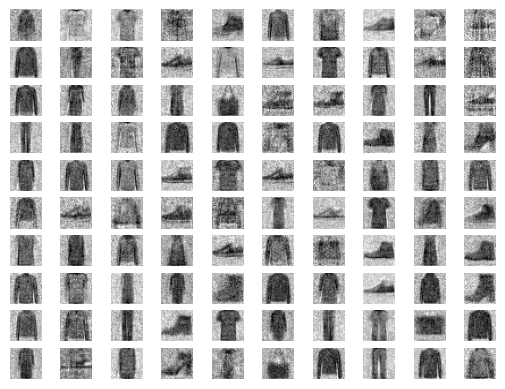

In [ ]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

1/1 [==============================] - 0s 62ms/step


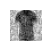

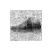

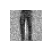

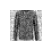

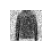

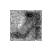

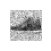

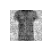

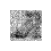

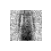

In [ ]:
model = load_model('model_18740.h5')
latent_dim = 100
n_examples = 10
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0



for i in range(n_examples):
  pyplot.subplot(n_examples, n_examples, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
  pyplot.show()
